In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
reward_pc = torch.tensor([1,3, 3 , 1,-10,2,6, 5,-5,-10])
reward_npc = torch.tensor([0,-2,-3,-1,3, 5, -3, -1,1])
#index = id-1
# action_transform
action_transform = torch.tensor([[1,3,6,7],[2,4,6,8],[1,5,6,7]])

dialogue_mapping_NPC = {
    1:"hello witcher",
    2:"hey kid!",
    3:"How is it going on brave witcher lord?",
    4:"Witcher can you save us from the creature thats attacking us?",
    5:"Oe witcher,  defeat a monster for me.",
    6:"Lord witcher can you save us from the creature that is attacking us?",
    7:"We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night. Please lord witcher save us from the beast.",
    8:" We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night.",
    9:"No idea what monster attacked us if i knew i would be dead. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. You sure kid like you can handle it. Howls at nighhts. People are afraid to venture into the woods at night. Sure you can take care of it we dont want any more dead bodies."
}


dialogue_mapping_PC ={
    1:"Greetings",
    2:"Fine just busy fighting creatures from Void dimension",
    3:"Ok let me help you with it. What creature is it?",
    4:" I m gonna help you but i need to paid well for a contract like that. What kind of creature is it",
    5:"I don't have to bother with this work. farewell",
    6:" Ok, sir let me help you. What kind of creature is it.",
    7:"Sure it will take 500$ ",
    8:" Sure it will take 800$",
    9:"Sure it will take 1200$",
    10:"Sorry I am busy. I won't be able to do that."


}
good = False

def user_in(lister):
   
    
    for i in lister:

        print(dialogue_mapping_PC[i], i)
    x=input()
    return x

def user_good(lister):
   
    if len(lister) == 3:
        x= 3
        
    else:
        if good:
            x= 7
        else: 
            x=10

    return x

def user_bad(lister):
   
    if len(lister) == 3:
        x= 5
    else:
        x= 10 

    return x


In [3]:
class PolicyNetwork():
    def __init__(self,n_state,n_action,n_hidden=50,lr=0.001):
        self.model = nn.Sequential(
            nn.Linear(n_state,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_action),
            nn.Softmax()
        )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def predict(self,s):
        return self.model(torch.Tensor(s))

    def update(self, advantags, log_probs):
        policy_gradient =[]
        #print(zip(log_probs,advantags))
        #print(advantags)
        for log_prob , Gt in zip(log_probs, advantags):
           # print(log_prob, Gt)
            policy_gradient.append(-log_prob* Gt)
        
        print(policy_gradient)
        loss = torch.stack(policy_gradient).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, s):
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action , log_prob


In [4]:
class ValueNetwork():
    def __init__(self, n_state, n_hidden=50, lr = 0.05):
        self.criterion = nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1)

        )
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr)

    
    def update(self, s, y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred,Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        with torch.no_grad():
            return self.model(torch.Tensor(s))



In [5]:
class Environment_user():
    def __init__(self):
        self.state=(0,0) #(NPC, PC)
        self.superState = 0
    def PC_action(self,action_transformed):
        if self.superState ==0:
            return 1 
            ## code to ask input from the user
            # transform into the id

        elif self.superState == 1:
            if action_transformed == 3:
                return 2
       
            else:
                lister = [3,4,5]
                x= user_good(lister)
                return int(x)

        elif self.superState ==2:
            return 6

        elif self.superState ==3 :
            lister = [7,8,9,10]
            x= user_good(lister)
            return int(x)  

        else :
            return -1
        
    def return_reward(self):
        return reward_npc[self.state[0]-1] + reward_pc[self.state[1]-1]


    def next_state(self,action_transformed ):
        pc_action = self.PC_action(action_transformed)
        if pc_action ==-1:
            self.state =(-1,-1)
            return self.state
        self.state = (action_transformed,pc_action)
        if self.superState == 0:
            
            self.superState =1
        elif self.superState == 1:

            if action_transformed == 3:

                self.superState = 2
            elif pc_action == 5:
                self.superState =4

            else :
                self.superState=3


        elif self.superState ==2:
            global good
            good = True
            self.superState = 3

        elif self.superState ==3:
            self.superState = 4

        else:
            self.superState = 4
        
        return self.state
        

In [6]:
env = Environment_user()

In [7]:
def reinforce(env,estimator_policy,estimator_value, n_episode, gamma =1):
    for episode in range(n_episode):
        global good
        good = False
        log_probs =[]
        states =[]
        rewards = []
        is_done = False
        env.state=(0,0)
        env.superState = 0
        state = env.state

        while True:
            states.append(state)
            action, log_prob = estimator_policy.get_action(state)
            transform_action = action_transform[action,env.superState]
            print("NPC:",dialogue_mapping_NPC[transform_action.item()])
            next_state = env.next_state(transform_action)
            if next_state == (-1,-1):
                is_done = True
            if env.superState == 4:
                is_done = True
            print("PC:",dialogue_mapping_PC[next_state[1]])
#            pause = input()
            reward =env.return_reward()

            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)

            if is_done:
                Gt=0 
                pw = 0 
                returns = []
                for t in range(len(states)-1,-1,-1):
                    
                    Gt += gamma ** pw * rewards[t]
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
          
                baseline_values = estimator_value.predict(states)
                advantages = returns - baseline_values
                estimator_value.update(states,returns)
                estimator_policy.update(advantages, log_probs)
                print('Episode:{}, total reward: {}'.format(episode, total_reward_episode[episode]))
                break
            state = next_state
            

                

            


In [8]:
n_state  =2
n_action = 3
n_hidden_p = 64
lr_p = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden_p , lr_p)

n_hidden_v = 64
lr_v = 0.003
value_net = ValueNetwork(n_state, n_hidden_v, lr_v)
gamma=0.9

In [9]:
n_episode = 500
total_reward_episode = [0] * n_episode
reinforce(env, policy_net, value_net, n_episode, gamma)

/home/prayash/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/prayash/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/prayash/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NPC: hello witcher
PC: Greetings
NPC: Witcher can you save us from the creature thats attacking us?
PC: Ok let me help you with it. What creature is it?
NPC:  We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls at nighhts. People are afraid to venture into the woods at night.
PC: Sorry I am busy. I won't be able to do that.
[tensor([-12.0429, -12.0429, -12.0429], grad_fn=<MulBackward0>), tensor([-5.3161, -5.3161, -5.3161], grad_fn=<MulBackward0>), tensor([-1.9599, -1.9599, -1.9599], grad_fn=<MulBackward0>)]
Episode:0, total reward: -8
NPC: hey kid!
PC: Greetings
NPC: Witcher can you save us from the creature thats attacking us?
PC: Ok let me help you with it. What creature is it?
NPC: We don't know what monster attacked us but it was vicious. It must have to huge as it slaughtered no less than a dozen wolves. Ripped their guts out, but left lost uneaten. Howls 

In [10]:
total_reward_episode[-20:]

[tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(11),
 tensor(9),
 tensor(11)]

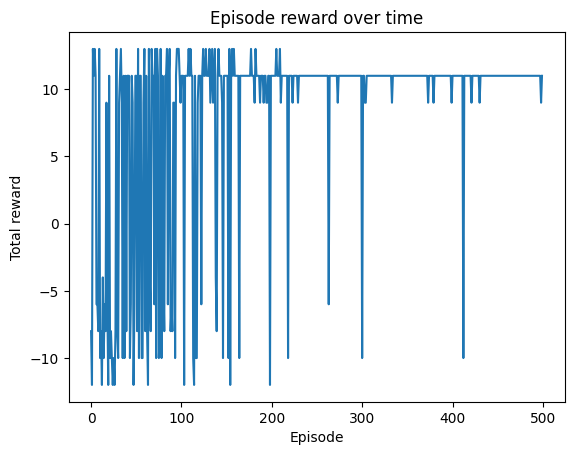

In [11]:

import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
